# Embedding Evaluation Overview

In this notebook, we evaluate various embeddings generated by different models, such as autoencoders, VAEs, and GANs. These embeddings are typically lower-dimensional representations of high-dimensional data, which are often used for tasks like clustering, classification, and retrieval. Our goal is to assess the quality of these embeddings in terms of their ability to represent underlying structures in the data. We also examine their effectiveness in clustering, classification, and comparison to real data distributions.

### Key Metrics and Evaluation Methods

1. **Clustering Metrics**:
    - **Adjusted Rand Index (ARI)**: This metric evaluates how well the predicted clustering aligns with the ground truth, adjusting for random chance. ARI ranges from -1 to 1, where 1 means perfect agreement, 0 means random clustering, and negative values indicate worse than random clustering. It is useful for assessing the overall quality of clustering solutions.
    - **Silhouette Score**: This score measures how well-separated the clusters are. It compares the distance between each point and the centroid of its own cluster with the distance to the nearest cluster. A higher score (close to +1) indicates well-separated clusters, while a lower score (close to -1) indicates poor clustering.
    - **Calinski-Harabasz Index**: This metric measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values generally indicate better clustering as they suggest that clusters are well-separated and compact.
    - **Davies-Bouldin Index**: This index quantifies the separation between clusters, with lower values suggesting better clustering. It is useful for evaluating how distinct the clusters are from each other.

2. **k-Nearest Neighbors (k-NN) Accuracy**:
    - **k-NN Accuracy**: One of the simplest ways to evaluate embeddings is by using them as input to a k-NN classifier, a supervised learning algorithm that assigns a class to a data point based on the majority class of its nearest neighbors. The accuracy of this classifier on the test data is used as a metric of embedding quality. Higher accuracy suggests that the embeddings contain enough discriminative information to separate data points effectively.

3. **Cross-Validation k-NN Accuracy**:
    - **Cross-Validation**: To avoid overfitting to a specific data split, k-NN accuracy is calculated with cross-validation. This involves splitting the dataset into multiple folds, training the classifier on different subsets, and evaluating it on the remaining data. This provides a more reliable and generalized estimate of the model's performance on unseen data.

4. **Fréchet Inception Distance (FID)**:
    - **FID**: The FID is a metric used primarily in generative models to compare real and generated data distributions. It is based on the assumption that both distributions (real and generated) can be approximated by multivariate Gaussian distributions. The FID computes the distance between the means and covariances of these two distributions. Lower FID scores indicate that the generated data is closer to the real data, which is useful for evaluating the realism of generated embeddings.

5. **Inception Score (IS)**:
    - **IS**: The Inception Score is used to evaluate the diversity and quality of generated embeddings. It measures how much the generated samples resemble a target distribution, with higher scores indicating both diversity (distinct classes) and quality (samples resemble real data). This is especially useful when evaluating generative models, as it quantifies both the visual fidelity and the diversity of the generated samples.

6. **Visualization**:
    - **Dimensionality Reduction**: Since embeddings often live in high-dimensional spaces, dimensionality reduction techniques like PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) are used to project them into a 2D space for visualization. These methods help in understanding the structure of the embeddings, such as how well-separated the data points are and how much variance is retained from the original space.
    - **Cluster Overlay**: We also perform KMeans clustering on the embeddings and overlay the cluster assignments onto the 2D visualization. This helps to visually assess how well the embeddings group similar data points together and whether the clusters correspond to meaningful groupings in the data.

### Evaluation Workflow

1. **Data Conversion**:
   - Since embeddings and labels may come in various formats (e.g., PyTorch tensors or NumPy arrays), we first ensure that both are converted to NumPy arrays for compatibility with the evaluation functions. This step is crucial for ensuring that all evaluation methods work seamlessly.

2. **Clustering Evaluation**:
   - KMeans clustering is performed on the embeddings to group similar data points. The quality of the clustering is then evaluated using metrics such as ARI, Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index. These metrics provide insights into how well the embeddings separate distinct data classes.

3. **k-NN Evaluation**:
   - A k-NN classifier is trained using the embeddings, and its performance is measured by accuracy on a held-out test set. Cross-validation is also performed to evaluate the stability and generalizability of the embeddings in different splits of the data.

4. **FID & IS Calculation**:
   - The Fréchet Inception Distance (FID) and Inception Score (IS) are calculated to assess how well the generated embeddings match the distribution of real data and how diverse the generated embeddings are.

5. **Visualization**:
   - Dimensionality reduction is applied to the embeddings using PCA or t-SNE, reducing them to two dimensions for visualization. This allows us to create 2D scatter plots of the embeddings, which are then color-coded based on the ground truth labels. We also overlay KMeans cluster predictions to visually assess the clustering structure.

### Purpose and Utility

The techniques used in this notebook are vital for understanding the quality of embeddings generated by different models. By combining both quantitative metrics (such as clustering scores and k-NN accuracy) and qualitative visualizations, we can gain valuable insights into:
- **Cluster Structure**: How well the embeddings form meaningful clusters that match the ground truth or exhibit separability.
- **Discriminative Power**: How well the embeddings can distinguish between different classes or data points in supervised tasks like classification.
- **Generation Quality**: How similar the generated embeddings are to real data, and whether they exhibit the desired level of diversity and realism.
- **Interpretability**: The visualizations help in interpreting the structure of the embeddings and understanding the relationships between data points in a lower-dimensional space.

Overall, this notebook serves as a comprehensive framework for evaluating and comparing the performance of multiple embeddings, helping to identify which model produces the most useful and high-quality embeddings for further tasks or fine-tuning.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import logging
from datetime import datetime
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset


from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Repository path (adjust if needed)
repo_path = "/content/drive/MyDrive/GAN-thesis-project"

# Add repository path to sys.path for module imports
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Change working directory to the repository
os.chdir(repo_path)

# Verify the working directory
print(f"Current working directory: {os.getcwd()}")

from src.data_utils import (
    load_embeddings, analyze_embeddings
)

from src.evaluation import (
    evaluate_clustering_metrics,
    evaluate_embedding_quality,
    evaluate_embedding_quality_cv,
    calculate_fid,
    calculate_inception_score,
    visualize_embeddings,
    overlay_clusters,
    evaluate_multiple_embeddings
)

# Set random seed and device
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/GAN-thesis-project
Using device: cpu


In [4]:
import torch
from torch.utils.data import DataLoader
import numpy as np

def load_embeddings_v2(embedding_file, device, batch_size=64, subset_size=None):
    """
    Loads embeddings and their associated labels from a specified file, selects a subset
    of the embeddings if specified, and creates a DataLoader for batching the embeddings.

    Args:
        embedding_file (str): Path to the file containing embeddings and labels.
        device (torch.device): The device (CPU/GPU) to load the tensors onto.
        batch_size (int, optional): The batch size for DataLoader. Default is 64.
        subset_size (int, optional): Number of embeddings to sample from the dataset. If None, all embeddings are used.

    Returns:
        tuple: A tuple containing:
            - embeddings (torch.Tensor): Loaded embeddings (or subset of them).
            - labels (torch.Tensor): Corresponding labels for the embeddings.
            - data_loader (DataLoader): DataLoader for batching embeddings.
    """
    print(f"Loading embeddings from: {embedding_file}")
    data = torch.load(embedding_file)
    embeddings = data["embeddings"].to(device)
    labels = data["labels"].to(device)

    # If subset_size is specified, take a random subset of the embeddings and labels
    if subset_size is not None:
        # Ensure the subset size is not larger than the total number of embeddings
        subset_size = min(subset_size, embeddings.shape[0])
        indices = torch.randperm(embeddings.shape[0])[:subset_size]
        embeddings = embeddings[indices]
        labels = labels[indices]

    # Create DataLoader for embeddings
    data_loader = DataLoader(embeddings, batch_size=batch_size, shuffle=True)

    return embeddings, labels, data_loader


In [5]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "matrix_factorization_PCA/matrix_factorization_default_loss_PCA_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([10000, 50])
IN

Loading embeddings from: ./saved_embeddings/embeddings/matrix_factorization_PCA/matrix_factorization_default_loss_PCA_embeddings.pt


INFO - Mean: -0.004459313116967678
INFO - Standard Deviation: 2.8278300762176514
INFO - Min: -71.0512466430664
INFO - Max: 95.28905487060547
INFO - Median: -0.03018050268292427
INFO - Mean L2 Norm: 18.413442611694336
INFO - Standard Deviation of L2 Norms: 7.7963175773620605
INFO - Each embedding has 50 dimensions.
INFO - Sparsity (proportion of non-zero elements): 1.0
INFO - Skewness of embeddings: 0.6098787362678385
INFO - Kurtosis of embeddings: 14.58138783258222
INFO - Pairwise distance (mean): 26.54570997461563
INFO - Average Cosine similarity with true labels: -0.015462168492376804
INFO - Number of outliers detected in embeddings: 219
INFO - Embeddings analysis completed.


In [2]:
## OLD VERSION

embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "kernel_pca_Kernel PCA/matrix_factorization_default_loss_kernel_pca_Kernel PCA_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings(embedding_file, device)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

/content/drive/MyDrive/GAN-thesis-project/src/data_utils.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of sha

Loading embeddings from: ./saved_embeddings/embeddings/kernel_pca_Kernel PCA/matrix_factorization_default_loss_kernel_pca_Kernel PCA_embeddings.pt


INFO - Number of outliers detected in embeddings: 0
INFO - Embeddings analysis completed.


INFO - Adjusted Rand Index (ARI): 0.2923
INFO - Silhouette Score: 0.0683
INFO - Calinski-Harabasz Index: 416.3796
INFO - Davies-Bouldin Index: 2.4019


Clustering Metrics:
ARI: 0.2923
Silhouette Score: 0.0683
Calinski-Harabasz Index: 416.3796
Davies-Bouldin Index: 2.4019


INFO - k-NN Accuracy: 0.9300



k-NN Accuracy: 0.9300


INFO - k-NN Accuracy (CV) - Mean: 0.9300, Std: 0.0060



k-NN Accuracy (CV) - Mean: 0.9300, Std: 0.0060


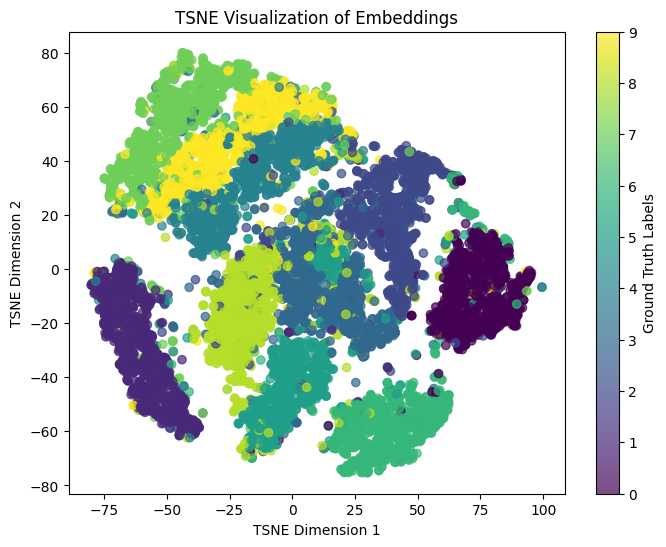

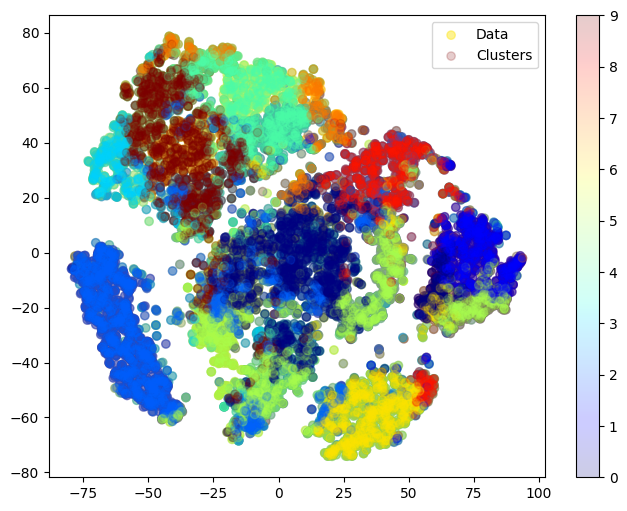

In [9]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

In [11]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "matrix_factorization_SVD/matrix_factorization_default_loss_SVD_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([10000, 50])
IN

Loading embeddings from: ./saved_embeddings/embeddings/matrix_factorization_SVD/matrix_factorization_default_loss_SVD_embeddings.pt


INFO - Pairwise distance (mean): 26.214038727035646
INFO - Average Cosine similarity with true labels: -0.014635644853115082
INFO - Number of outliers detected in embeddings: 220
INFO - Embeddings analysis completed.


INFO - Adjusted Rand Index (ARI): 0.3165
INFO - Silhouette Score: 0.0768
INFO - Calinski-Harabasz Index: 441.7257
INFO - Davies-Bouldin Index: 2.4107
INFO - k-NN Accuracy: 0.9305


Clustering Metrics:
ARI: 0.3165
Silhouette Score: 0.0768
Calinski-Harabasz Index: 441.7257
Davies-Bouldin Index: 2.4107

k-NN Accuracy: 0.9305


INFO - k-NN Accuracy (CV) - Mean: 0.9294, Std: 0.0039



k-NN Accuracy (CV) - Mean: 0.9294, Std: 0.0039


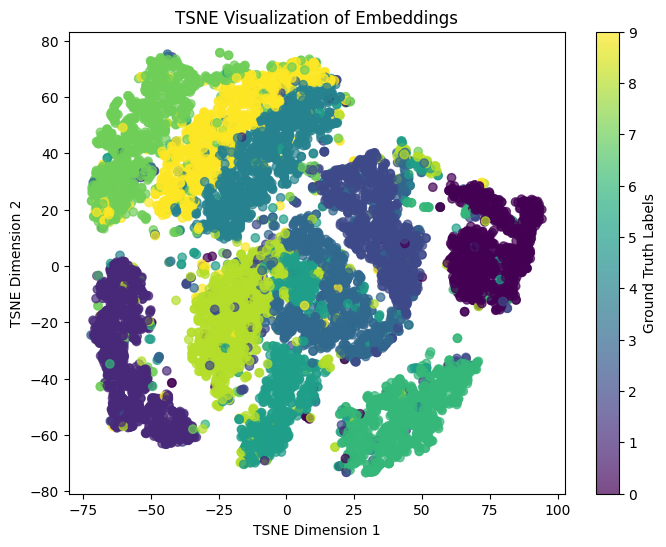

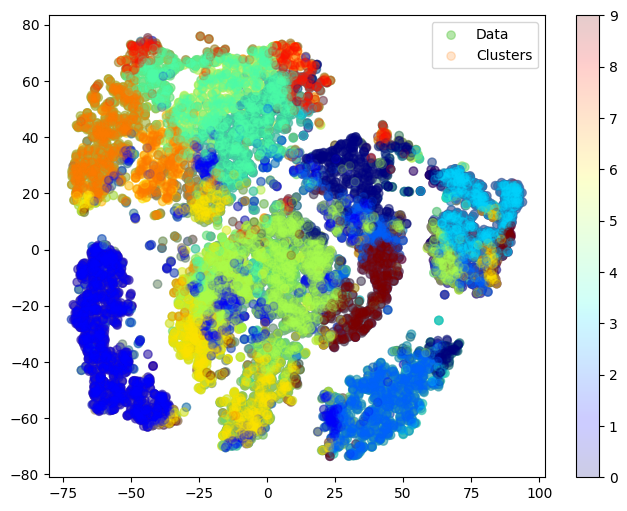

In [12]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

In [13]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "matrix_factorization_NMF/matrix_factorization_default_loss_NMF_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([10000, 50])
IN

Loading embeddings from: ./saved_embeddings/embeddings/matrix_factorization_NMF/matrix_factorization_default_loss_NMF_embeddings.pt


INFO - Pairwise distance (mean): 0.20851073454016156
INFO - Average Cosine similarity with true labels: 0.4304857850074768
INFO - Number of outliers detected in embeddings: 142
INFO - Embeddings analysis completed.


INFO - Adjusted Rand Index (ARI): 0.1863
INFO - Silhouette Score: 0.0992
INFO - Calinski-Harabasz Index: 654.8443
INFO - Davies-Bouldin Index: 2.3403
INFO - k-NN Accuracy: 0.8570


Clustering Metrics:
ARI: 0.1863
Silhouette Score: 0.0992
Calinski-Harabasz Index: 654.8443
Davies-Bouldin Index: 2.3403

k-NN Accuracy: 0.8570


INFO - k-NN Accuracy (CV) - Mean: 0.8634, Std: 0.0054



k-NN Accuracy (CV) - Mean: 0.8634, Std: 0.0054


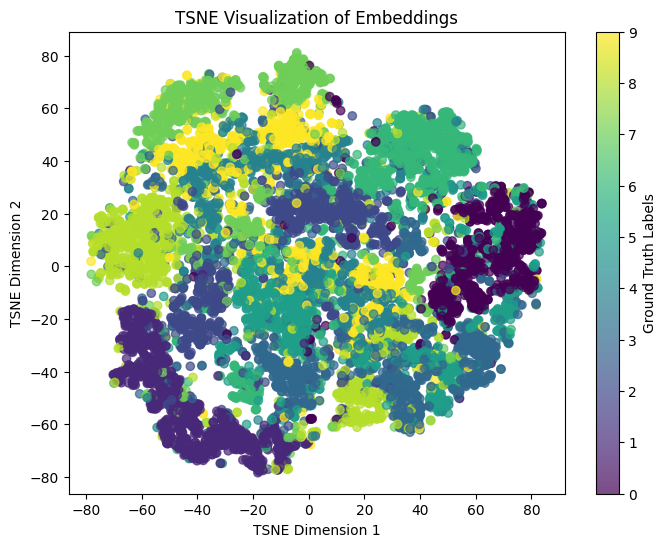

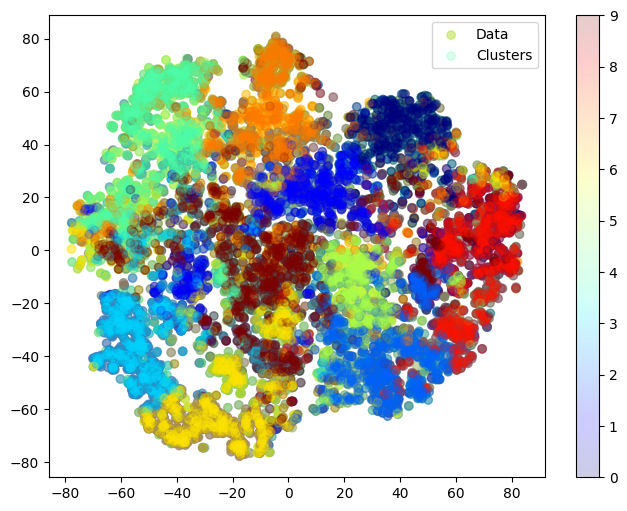

In [14]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

In [15]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "autoencoders_AdvancedAutoencoder_mse/AdvancedAutoencoder_mse_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_AdvancedAutoencoder_mse/AdvancedAutoencoder_mse_embeddings.pt


<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([7000, 50])
INF

INFO - Adjusted Rand Index (ARI): 0.3289
INFO - Silhouette Score: 0.0726
INFO - Calinski-Harabasz Index: 283.6755
INFO - Davies-Bouldin Index: 2.6346
INFO - k-NN Accuracy: 0.9486


Clustering Metrics:
ARI: 0.3289
Silhouette Score: 0.0726
Calinski-Harabasz Index: 283.6755
Davies-Bouldin Index: 2.6346

k-NN Accuracy: 0.9486


INFO - k-NN Accuracy (CV) - Mean: 0.9446, Std: 0.0042



k-NN Accuracy (CV) - Mean: 0.9446, Std: 0.0042


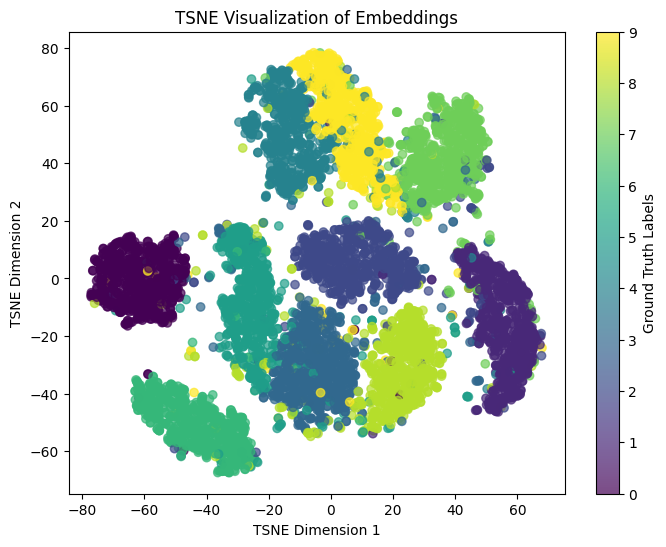

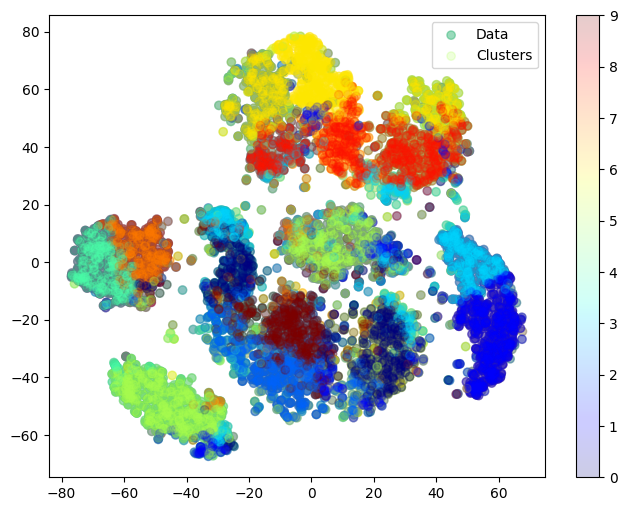

In [16]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

In [22]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "autoencoders_AdvancedAutoencoder/AdvancedAutoencoder_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_AdvancedAutoencoder/AdvancedAutoencoder_embeddings.pt


<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([7000, 50])
INF

INFO - Adjusted Rand Index (ARI): 0.3975
INFO - Silhouette Score: 0.0817
INFO - Calinski-Harabasz Index: 332.6067
INFO - Davies-Bouldin Index: 2.5542
INFO - k-NN Accuracy: 0.9443


Clustering Metrics:
ARI: 0.3975
Silhouette Score: 0.0817
Calinski-Harabasz Index: 332.6067
Davies-Bouldin Index: 2.5542

k-NN Accuracy: 0.9443


INFO - k-NN Accuracy (CV) - Mean: 0.9391, Std: 0.0069



k-NN Accuracy (CV) - Mean: 0.9391, Std: 0.0069


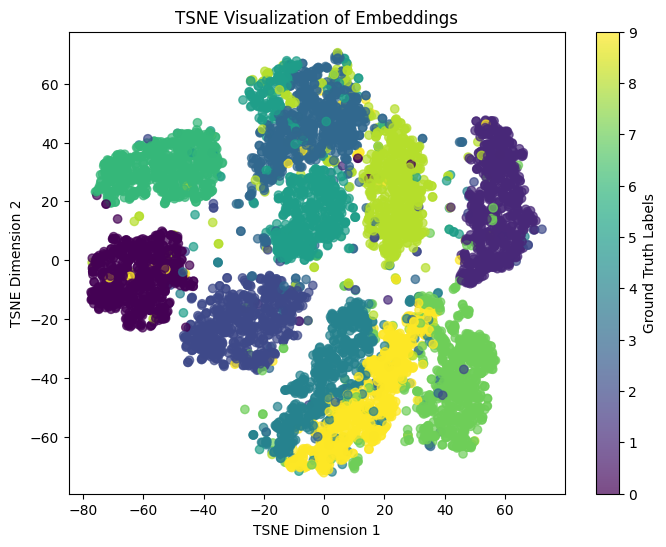

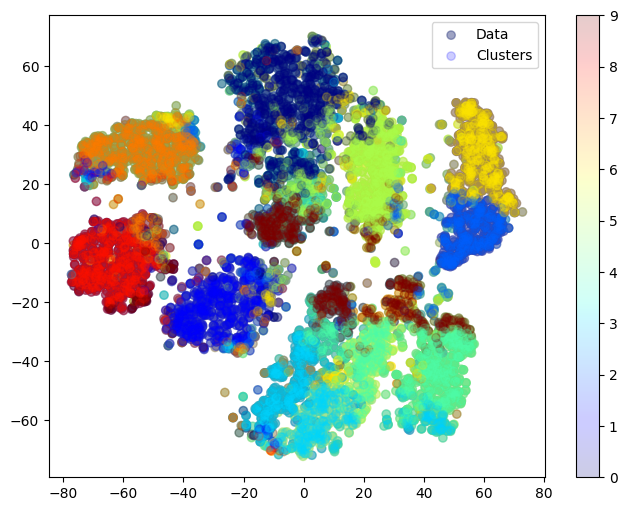

In [23]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

In [24]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "autoencoders_IntermediateAutoencoder_mse/IntermediateAutoencoder_mse_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_IntermediateAutoencoder_mse/IntermediateAutoencoder_mse_embeddings.pt


<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([7000, 50])
INF

INFO - Adjusted Rand Index (ARI): 0.4102
INFO - Silhouette Score: 0.0813
INFO - Calinski-Harabasz Index: 317.1889
INFO - Davies-Bouldin Index: 2.5108
INFO - k-NN Accuracy: 0.9436


Clustering Metrics:
ARI: 0.4102
Silhouette Score: 0.0813
Calinski-Harabasz Index: 317.1889
Davies-Bouldin Index: 2.5108

k-NN Accuracy: 0.9436


INFO - k-NN Accuracy (CV) - Mean: 0.9477, Std: 0.0062



k-NN Accuracy (CV) - Mean: 0.9477, Std: 0.0062


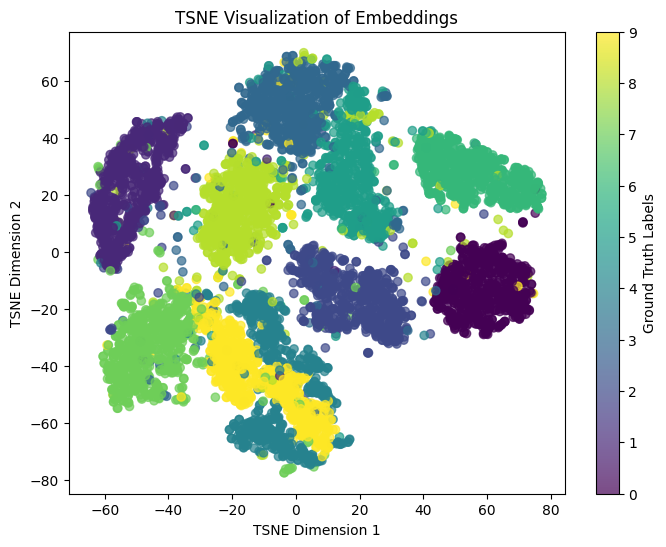

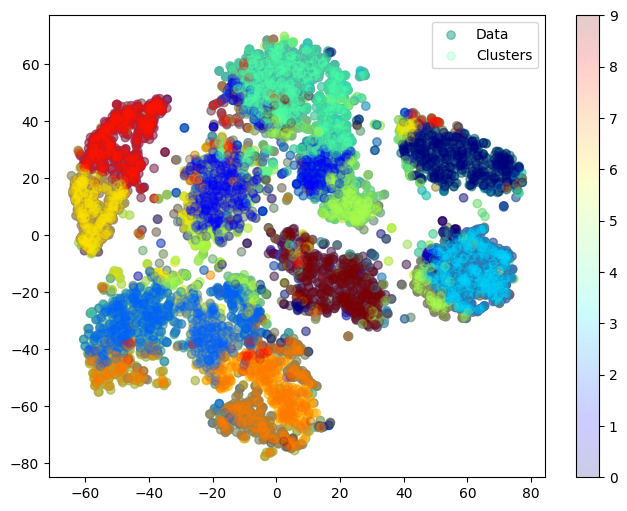

In [25]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

In [26]:
embedding_dir = "./saved_embeddings/embeddings/"  # Example embedding path
embedding_file = os.path.join(embedding_dir, "autoencoders_BasicAutoencoder_mse/BasicAutoencoder_mse_embeddings.pt")

# Load embeddings and labels using the new function
embeddings, labels, data_loader = load_embeddings_v2(embedding_file, device, subset_size= 10000)

# Analyze the embeddings (optional: set expected_dim if necessary)
analyze_embeddings(embeddings, expected_dim=50, labels=labels)

Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_BasicAutoencoder_mse/BasicAutoencoder_mse_embeddings.pt


<ipython-input-4-f3c1988860e7>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(embedding_file)
INFO - Embeddings are of shape: torch.Size([7000, 50])
INF

INFO - Adjusted Rand Index (ARI): 0.4495
INFO - Silhouette Score: 0.1229
INFO - Calinski-Harabasz Index: 449.2054
INFO - Davies-Bouldin Index: 2.2155
INFO - k-NN Accuracy: 0.9557


Clustering Metrics:
ARI: 0.4495
Silhouette Score: 0.1229
Calinski-Harabasz Index: 449.2054
Davies-Bouldin Index: 2.2155

k-NN Accuracy: 0.9557


INFO - k-NN Accuracy (CV) - Mean: 0.9450, Std: 0.0043



k-NN Accuracy (CV) - Mean: 0.9450, Std: 0.0043


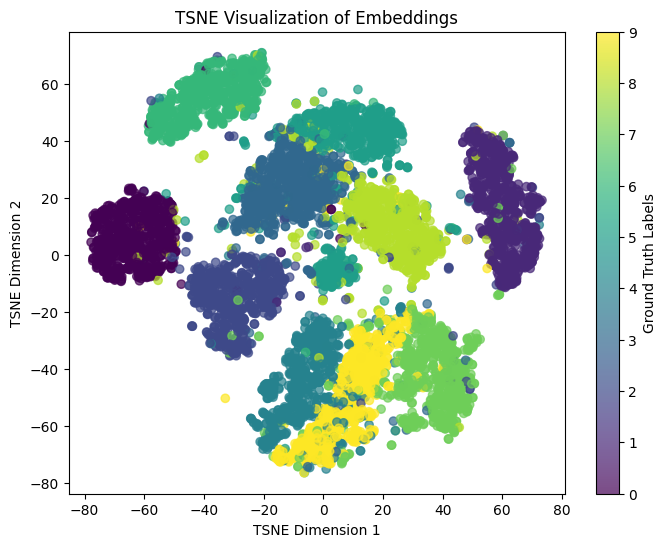

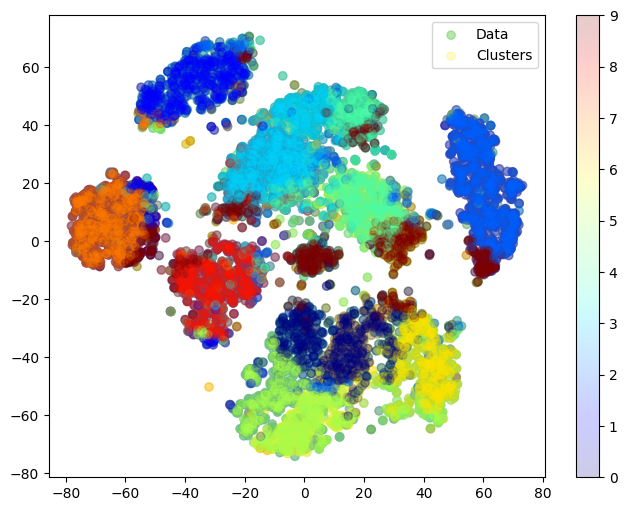

In [27]:
# Evaluate Clustering Metrics
clustering_metrics = evaluate_clustering_metrics(embeddings, labels, n_clusters=10)
print("Clustering Metrics:")
for metric_name, metric_value in clustering_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# Evaluate k-NN Accuracy
knn_accuracy = evaluate_embedding_quality(embeddings, labels, k=5)
print(f"\nk-NN Accuracy: {knn_accuracy:.4f}")

# Evaluate k-NN Accuracy with Cross-Validation
knn_accuracy_cv_mean, knn_accuracy_cv_std = evaluate_embedding_quality_cv(embeddings, labels, k=5, cv=5)
print(f"\nk-NN Accuracy (CV) - Mean: {knn_accuracy_cv_mean:.4f}, Std: {knn_accuracy_cv_std:.4f}")

# Visualize the embeddings using PCA or t-SNE
visualize_embeddings(embeddings, labels, method="tsne")  # Or use "pca" for PCA visualization

# Overlay clusters on the embeddings using KMeans
overlay_clusters(embeddings, labels, n_clusters=10, method="tsne")  # Or use "pca" for PCA visualization

# Example of evaluating multiple embeddings if you have them in a list:
# embeddings_list = [embedding1, embedding2, embedding3]  # Replace with actual embeddings
# multiple_results = evaluate_multiple_embeddings(embeddings_list, labels, n_clusters=10, k=5)

## GAN

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Mount Google Drive and set repository path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Repository path (adjust if needed)
repo_path = "/content/drive/MyDrive/GAN-thesis-project"

# Add repository path to sys.path for module imports
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Change working directory to the repository
os.chdir(repo_path)

# Verify the working directory
print(f"Current working directory: {os.getcwd()}")

# Data Utilities
from src.data_utils import (
    preprocess_images,
    load_mnist_data,
    load_data
)

# Importing the loss functions and related classes
from src.cl_loss_function import (
    contrastive_loss,
    info_nce_loss,
    nt_xent_loss,
    NTXentLoss,
    TripletLoss
)

# Encoder Models
from src.embeddings.encoder_models import (
    BasicAutoencoder,
    IntermediateAutoencoder,
    AdvancedAutoencoder,
    EnhancedAutoencoder,
    BasicVAE,
    VAEWithFCDecoder,
    ImprovedVAE,
    FlexibleVAE,
    DenoisingAutoencoder,
    process_matrix_factorization,
    process_feature_extraction,
    apply_dimensionality_reduction,
    create_embedding_loaders,
    apply_sift,
    NormalizingFlowModel,
    train_nf_model
)

# Encoder Training
from src.embeddings.encoder_training import (
    train_autoencoder,
    train_with_triplet_loss,
    train_with_ntxent_loss,
    train_vae,
    train_denoising_autoencoder,
    vae_loss,
    vae_ssim_loss,
    VicRegLoss,
    train_dae_ssim_contrastive,
    loss_function_dae_ssim,
    train_dae_with_triplet,
    train_vae_ssim_contrastive,
    train_vae_ssim,
    train_vae_improved
)

# Configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/GAN-thesis-project
Using device: cpu


Sampled Dataset: (70000, 1, 28, 28) (70000,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


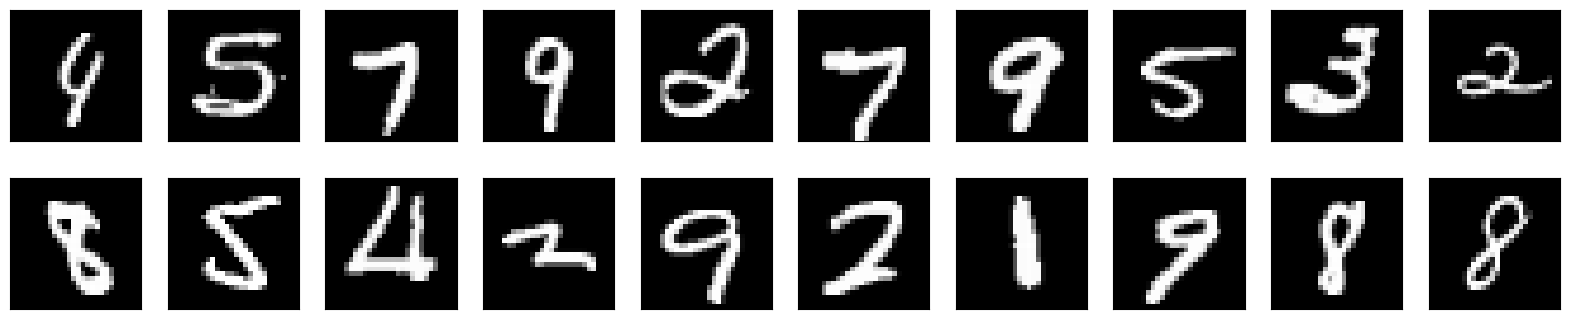

In [5]:
# Load and Preprocess MNIST Data
fraction = 1  # Fraction of the dataset to use
batch_size = 64

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = load_mnist_data(fraction=fraction, batch_size=batch_size, shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [8]:
sampled_images = mnist_loader.dataset.tensors[0].numpy()
print(sampled_images.shape)

(70000, 1, 28, 28)


In [14]:
sampled_x, sampled_y = mnist_loader.dataset.tensors[0].numpy(), mnist_loader.dataset.tensors[1].numpy()
print(sampled_x.shape)

(70000, 1, 28, 28)


In [10]:
print(sampled_x.shape)

torch.Size([64, 1, 28, 28])


In [ ]:
# ------------------------------
# Step 1: Configuration
# ------------------------------

save_format = "pt"  # Change to "npy" if needed

# Ensure valid save format
if save_format not in ['pt', 'npy']:
    print(f"Invalid save format: {save_format}. Defaulting to 'pt'.")
    save_format = 'pt'

# Define model and loss type for naming conventions (update as needed)
model_name = "matrix_factorization"  # Example model name
loss_type = "default_loss"  # Update this as necessary (e.g., "mse", "contrastive", etc.)

# ------------------------------
# Step 2: Matrix Factorization
# ------------------------------

# Extract flattened images and labels
sampled_x, sampled_y = mnist_loader.dataset.tensors[0].numpy(), mnist_loader.dataset.tensors[1].numpy()


print("Processing matrix factorization models (PCA, SVD, NMF)...")
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

factorized_embeddings, factorized_labels = process_matrix_factorization(
    sampled_x, sampled_y, n_components=50
)
for method, embeddings in factorized_embeddings.items():
    embedding_subdir = f"matrix_factorization_{method}"
    embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    if save_format == "pt":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_{method}_embeddings.pt")
        torch.save({"embeddings": embeddings, "labels": factorized_labels}, embedding_file)
        print(f"{method} embeddings saved in PyTorch format: {embedding_file}")
    elif save_format == "npy":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_{method}_embeddings.npy")
        np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": factorized_labels.numpy()})
        print(f"{method} embeddings saved in NumPy format: {embedding_file}")
    else:
        raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 3: SIFT Features
# ------------------------------

print("Processing SIFT features...")
sift_features = apply_sift(sampled_x, n_features=50)
sift_labels = torch.tensor(sampled_y, dtype=torch.long)

embedding_subdir = "sift_features"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_sift_embeddings.pt")
    torch.save({"embeddings": torch.tensor(sift_features), "labels": sift_labels}, embedding_file)
    print(f"SIFT embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_sift_embeddings.npy")
    np.save(embedding_file, {"embeddings": sift_features, "labels": sift_labels.numpy()})
    print(f"SIFT embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 4: Kernel PCA
# ------------------------------

print("Processing Kernel PCA...")
kernel_pca_features, kernel_pca_labels = process_feature_extraction(
    sampled_x, sampled_y, n_features=50, kernel="rbf", n_components=50
)
for method, embeddings in kernel_pca_features.items():
    embedding_subdir = f"kernel_pca_{method}"
    embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    if save_format == "pt":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_kernel_pca_{method}_embeddings.pt")
        torch.save({"embeddings": embeddings, "labels": kernel_pca_labels}, embedding_file)
        print(f"{method} Kernel PCA embeddings saved in PyTorch format: {embedding_file}")
    elif save_format == "npy":
        embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_kernel_pca_{method}_embeddings.npy")
        np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": kernel_pca_labels.numpy()})
        print(f"{method} Kernel PCA embeddings saved in NumPy format: {embedding_file}")
    else:
        raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 5: Normalizing Flow
# ------------------------------

print("Processing Normalizing Flow...")
for method, embeddings in factorized_embeddings.items():
    # Initialize Normalizing Flow model
    input_dim = embeddings.size(1)
    nf_model = NormalizingFlowModel(input_dim=input_dim, num_flows=4)
    nf_model.to(device)

    # Train Normalizing Flow model
    trained_nf_model = train_nf_model(
        nf_model, embeddings, num_epochs=200, lr=1e-3, batch_size=128
    )

    # Refine embeddings
    with torch.no_grad():
        refined_embeddings, _ = trained_nf_model(embeddings)

        embedding_subdir = f"normalizing_flow_{method}"
        embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
        os.makedirs(embedding_dir, exist_ok=True)

        if save_format == "pt":
            embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_normalizing_flow_{method}_refined_embeddings.pt")
            torch.save({"embeddings": refined_embeddings, "labels": factorized_labels}, embedding_file)
            print(f"{method} refined embeddings (Normalizing Flow) saved in PyTorch format: {embedding_file}")
        elif save_format == "npy":
            embedding_file = os.path.join(embedding_dir, f"{model_name}_{loss_type}_normalizing_flow_{method}_refined_embeddings.npy")
            np.save(embedding_file, {"embeddings": refined_embeddings.numpy(), "labels": factorized_labels.numpy()})
            print(f"{method} refined embeddings (Normalizing Flow) saved in NumPy format: {embedding_file}")
        else:
            raise ValueError(f"Unsupported save format: {save_format}")

print("Feature extraction and normalizing flow processing complete!")


Processing matrix factorization models (PCA, SVD, NMF)...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_PCA/matrix_factorization_default_loss_PCA_embeddings.pt
SVD embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_SVD/matrix_factorization_default_loss_SVD_embeddings.pt
NMF embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_NMF/matrix_factorization_default_loss_NMF_embeddings.pt
Processing SIFT features...
SIFT embeddings saved in PyTorch format: ./saved_embeddings/embeddings/sift_features/matrix_factorization_default_loss_sift_embeddings.pt
Processing Kernel PCA...
